100%|█████████████████████████████████████████████████████████████████| 300/300 [02:50<00:00,  1.76it/s, ELBO=-1.94e+09]


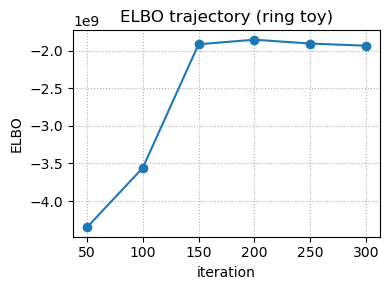

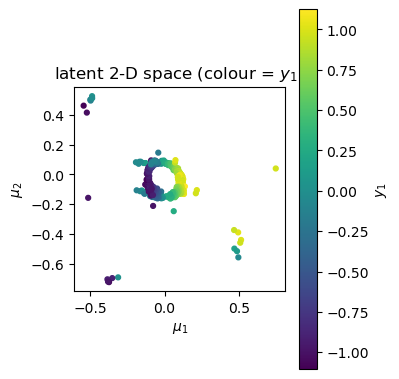

In [1]:
import math, torch, tqdm, matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, Optional

torch.set_default_dtype(torch.float64)
plt.rcParams["figure.autolayout"] = True


def _device() -> str:
    return "cuda" if torch.cuda.is_available() else "cpu"

def _rho(t: int, t0: float, kappa: float) -> float:
    return (t0 + t) ** (-kappa)

def _circle_init(Y: torch.Tensor, Q: int) -> torch.Tensor:
    theta = torch.linspace(0, 2 * math.pi, Y.size(0) + 1, device=Y.device)[:-1]
    return torch.stack([torch.sin(theta), torch.cos(theta)], 1)[:, :Q]


@dataclass
class GPLVMConfig:
    latent_dim: int = 2
    inducing_grid: int = 8
    lr_inner: float = 1e-2
    lr_hyp: float = 2e-4
    robbins_t0: float = 50.0
    robbins_kappa: float = 0.9
    prior_x_var: float = 5.0
    init_mu: Callable[[torch.Tensor, int], torch.Tensor] = _circle_init
    init_log_s2x: float = -2.0
    init_log_sf2: float = 0.0
    init_log_beta_inv: float = -3.0
    init_log_alpha: Optional[torch.Tensor] = None
    device: str = field(default_factory=_device)


class GPLVM_SSVI:
    def __init__(self, Y: torch.Tensor, cfg: GPLVMConfig):
        self.cfg = cfg
        self.Y = Y.to(cfg.device)
        self.N, self.D = Y.shape
        self.Q = cfg.latent_dim
        self.dev = cfg.device

        g = torch.linspace(-1.5, 1.5, cfg.inducing_grid, device=self.dev)
        grid = torch.meshgrid(*[g]*self.Q, indexing="ij")
        self.Z = torch.stack(grid, -1).reshape(-1, self.Q)
        self.M = self.Z.size(0)

        self.log_sf2 = torch.tensor(cfg.init_log_sf2, device=self.dev, requires_grad=True)
        self.log_beta_inv = torch.tensor(cfg.init_log_beta_inv, device=self.dev, requires_grad=True)
        self.log_alpha = (
            cfg.init_log_alpha.to(self.dev).requires_grad_()
            if cfg.init_log_alpha is not None
            else torch.zeros(self.Q, device=self.dev, requires_grad=True)
        )
        self.opt_hyp = torch.optim.Adam([self.log_sf2, self.log_alpha, self.log_beta_inv], lr=cfg.lr_hyp)

        with torch.no_grad():
            s2_u = torch.full((self.D, self.M), 1e-2, device=self.dev)
            self.h_u = torch.zeros_like(s2_u)
            self.lam_u = -0.5 / s2_u
        self.h_u.requires_grad_(False)
        self.lam_u.requires_grad_(False)

        self.mu_x = cfg.init_mu(self.Y, self.Q).to(self.dev).detach().requires_grad_()
        self.log_s2x = torch.full_like(self.mu_x, cfg.init_log_s2x, requires_grad=True)
        self.opt_loc = torch.optim.Adam([self.mu_x, self.log_s2x], lr=cfg.lr_inner)

        self.e_it, self.e_val = [], []

    def _k(self, x, z):
        a = self.log_alpha.exp()
        return self.log_sf2.exp() * torch.exp(-0.5 * ((x.unsqueeze(-2) - z)**2 * a).sum(-1))

    def _Kmm(self):
        return self._k(self.Z, self.Z) + 1e-6 * torch.eye(self.M, device=self.dev)

    def _noise_var(self):
        return self.log_beta_inv.exp()

    def _psi(self, mu, s2):
        sf2, a = self.log_sf2.exp(), self.log_alpha.exp()
        S = mu.size(0)

        psi0 = sf2.expand(S)

        d1 = a * s2 + 1.0
        c1 = d1.rsqrt().prod(-1, keepdim=True)
        psi1 = sf2 * c1 * torch.exp(
            -0.5 * ((a * (mu[:, None, :] - self.Z) ** 2) / d1[:, None, :]).sum(-1)
        )

        d2 = a * s2 + 2.0
        c2 = d2.rsqrt().prod(-1, keepdim=True)
        ZZ = self.Z[:, None, :] - self.Z[None, :, :]
        dist = (a * ZZ ** 2).sum(-1)
        mid = (self.Z[:, None, :] + self.Z[None, :, :]) / 2.0
        mu_c = (mu[:, None, None, :] - mid) ** 2
        expo = torch.exp(-0.25 * dist - 0.5 * ((a * mu_c) / d2[:, None, None, :]).sum(-1))
        psi2 = sf2 ** 2 * c2.unsqueeze(-1) * expo
        return psi0, psi1, psi2

    def _local(self, idx, U, mu_loc, log_s2_loc):
        Km = self._Kmm()
        Lm = torch.linalg.cholesky(Km)
        mu, s2 = mu_loc[idx], log_s2_loc[idx].exp()
        psi0, psi1, psi2 = self._psi(mu, s2)

        A = torch.cholesky_solve(psi1.T, Lm).T
        fmu = A @ U.T
        tr = torch.cholesky_solve(psi2, Lm).diagonal(0, -2, -1).sum(-1)
        sigma2 = (self._noise_var() + psi0 - tr).clamp_min(1e-8)
        log_like = (-0.5 * math.log(2 * math.pi)
                    - 0.5 * sigma2.log()[:, None]
                    - 0.5 * (self.Y[idx] - fmu) ** 2 / sigma2[:, None]).sum(-1)

        kl_x = 0.5 * ((s2 + mu ** 2) / self.cfg.prior_x_var
                     - s2.log() + math.log(self.cfg.prior_x_var) - 1).sum(-1)
        return (log_like - kl_x).mean(), (psi1, psi2, sigma2)

    def _KL_U(self):
        Km = self._Kmm()
        Lm = torch.linalg.cholesky(Km)
        Kin_diag = torch.cholesky_solve(torch.eye(self.M, device=self.dev), Lm).diag()
        var_u = -0.5 / self.lam_u
        mean_u = self.h_u * var_u
        tr = (Kin_diag * var_u).sum()
        quad = (Kin_diag * mean_u ** 2).sum()
        logdet_p = self.D * 2 * Lm.diagonal().log().sum()
        logdet_q = var_u.log().sum()
        return 0.5 * (tr + quad - self.D * self.M + logdet_p - logdet_q)

    def _sample_U(self):
        eps = torch.randn_like(self.h_u)
        var = -0.5 / self.lam_u
        return self.h_u * var + eps * torch.sqrt(var)

    @torch.no_grad()
    def _full_elbo(self):
        l, _ = self._local(torch.arange(self.N, device=self.dev), self._sample_U(), self.mu_x, self.log_s2x)
        return l - self._KL_U()

    def fit(self, num_iters=300, batch_size=128, inner=6, warmup=50):
        bar = tqdm.trange(1, num_iters + 1, ncols=120)
        for t in bar:
            idx = torch.randint(0, self.N, (batch_size,), device=self.dev)

            for _ in range(inner):
                self.opt_loc.zero_grad(set_to_none=True)
                le, _ = self._local(idx, self._sample_U().detach(), self.mu_x, self.log_s2x)
                (-le).backward()
                self.opt_loc.step()
                self.mu_x.detach_().requires_grad_()
                self.log_s2x.detach_().requires_grad_()

            U_s = self._sample_U()
            le, (psi1, _, sigma2) = self._local(idx, U_s, self.mu_x, self.log_s2x)
            if t >= warmup:
                self.opt_hyp.zero_grad(set_to_none=True)
                (-(le - self._KL_U())).backward()
                self.opt_hyp.step()

            rho_t = _rho(t, self.cfg.robbins_t0, self.cfg.robbins_kappa)
            with torch.no_grad():
                Km = self._Kmm()
                Lm = torch.linalg.cholesky(Km)
                A = torch.cholesky_solve(psi1.detach().T, Lm).T
                r_n = ((self.Y[idx] / sigma2[:, None])[:, :, None]) * A[:, None, :]
                q_n = -0.5 * (A ** 2) / sigma2[:, None]
                r_t = r_n.sum(0)
                q_t = q_n.sum(0).unsqueeze(0).expand(self.D, -1)
                deltaU = U_s - self.h_u * (-0.5 / self.lam_u)
                r_t += 2 * q_t * deltaU
                scale = self.N / batch_size
                lambda0 = -0.5 * torch.cholesky_solve(torch.eye(self.M, device=self.dev), Lm).diag()
                self.h_u += rho_t * (scale * r_t - self.h_u)
                self.lam_u += rho_t * (lambda0.unsqueeze(0) + scale * q_t - self.lam_u)
                self.lam_u.clamp_(max=-1e-8)

            if t % 50 == 0:
                e = self._full_elbo().item()
                self.e_it.append(t)
                self.e_val.append(e)
                bar.set_postfix({"ELBO": f"{e:.2e}"})
        return self

    def plot_elbo(self):
        plt.figure(figsize=(4, 3))
        plt.plot(self.e_it, self.e_val, "-o")
        plt.xlabel("iteration")
        plt.ylabel("ELBO")
        plt.title("ELBO trajectory (ring toy)")
        plt.grid(ls=":")
        plt.show()

    def plot_latents(self):
        if self.Q != 2:
            print("Latent scatter only for Q=2")
            return
        with torch.no_grad():
            plt.figure(figsize=(4, 4))
            plt.scatter(
                self.mu_x[:, 0].cpu(),
                self.mu_x[:, 1].cpu(),
                c=self.Y[:, 0].cpu(),
                cmap="viridis",
                s=12,
            )
            plt.gca().set_aspect("equal")
            plt.xlabel(r"$\mu_1$")
            plt.ylabel(r"$\mu_2$")
            plt.title("latent 2-D space (colour = $y_1$)")
            plt.colorbar(label="$y_1$")
            plt.show()


# test run
if __name__ == "__main__":
    torch.manual_seed(0)
    N = 400
    theta = torch.linspace(0, 2 * math.pi, N + 1)[:-1]
    r = 1.0 + 0.05 * torch.randn(N)
    Y = torch.stack([r * torch.sin(theta), r * torch.cos(theta)], 1)
    cfg = GPLVMConfig(latent_dim=2, inducing_grid=8, device="cpu")
    model = GPLVM_SSVI(Y, cfg).fit(num_iters=300, batch_size=128)
    model.plot_elbo()
    model.plot_latents()
